## 4.3 PyTorchでMNIST

In [1]:
# 手書き数字の画像データMNISTをダウンロード

from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home=".")  # data_homeは保存先を指定します


In [2]:
# 1. データの前処理（画像データとラベルに分割し、正規化）

X = mnist.data / 255  # 0-255を0-1に正規化
y = mnist.target


この画像データのラベルは0です


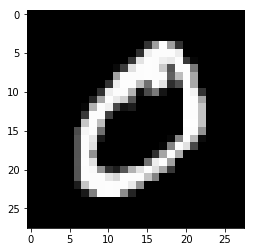

In [3]:
# MNISTのデータの1つ目を可視化する

import matplotlib.pyplot as plt
% matplotlib inline

plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("この画像データのラベルは{:.0f}です".format(y[0]))


In [4]:
# 2. DataLoderの作成

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 2.1 データを訓練とテストに分割（6:1）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7, random_state=0)

# 2.2 データをPyTorchのTensorに変換
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 2.3 データとラベルをセットにしたDatasetを作成
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# 2.4 データセットのミニバッチサイズを指定した、Dataloaderを作成
# Chainerのiterators.SerialIteratorと似ている
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)


In [5]:
# 3. ネットワークの構築
# Keras風の書き方 

from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)


Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [6]:
# 4. 誤差関数と最適化手法の設定

from torch import optim

# 誤差関数の設定
loss_fn = nn.CrossEntropyLoss()  # 変数名にはcriterionが使われることも多い

# 重みを学習する際の最適化手法の選択
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [7]:
# 5. 学習と推論の設定
# 5-1. 学習1回でやることを定義します
# Chainerのtraining.Trainer()に対応するものはない


def train(epoch):
    model.train()  # ネットワークを学習モードに切り替える

    # データローダーから1ミニバッチずつ取り出して計算する
    for data, targets in loader_train:
      
        optimizer.zero_grad()  # 一度計算された勾配結果を0にリセット
        outputs = model(data)  # 入力dataをinputし、出力を求める
        loss = loss_fn(outputs, targets)  # 出力と訓練データの正解との誤差を求める
        loss.backward()  # 誤差のバックプロパゲーションを求める
        optimizer.step()  # バックプロパゲーションの値で重みを更新する

    print("epoch{}：終了\n".format(epoch))


In [8]:
# 5. 学習と推論の設定
# 5-2. 推論1回でやることを定義します
# Chainerのtrainer.extend(extensions.Evaluator())に対応するものはない


def test():
    model.eval()  # ネットワークを推論モードに切り替える
    correct = 0

    # データローダーから1ミニバッチずつ取り出して計算する
    with torch.no_grad():  # 微分は推論では必要ない
        for data, targets in loader_test:

            outputs = model(data)  # 入力dataをinputし、出力を求める

            # 推論する
            _, predicted = torch.max(outputs.data, 1)  # 確率が最大のラベルを求める
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 正解と一緒だったらカウントアップ

    # 正解率を出力
    data_num = len(loader_test.dataset)  # データの総数
    print('\nテストデータの正解率: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))


In [9]:
# 学習なしにテストデータで推論してみよう
test()



テストデータの正解率: 981/10000 (9%)



In [10]:
# 6. 学習と推論の実行
for epoch in range(3):
    train(epoch)

test()


epoch0：終了

epoch1：終了

epoch2：終了


テストデータの正解率: 9611/10000 (96%)



予測結果は7
この画像データの正解ラベルは7です


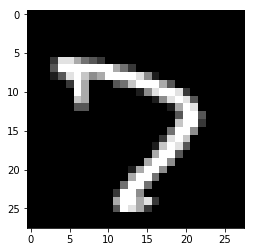

In [11]:
# 例えば2018番目の画像データを推論してみる

index = 2018

model.eval()  # ネットワークを推論モードに切り替える
data = X_test[index]
output = model(data)  # 入力dataをinputし、出力を求める
_, predicted = torch.max(output.data, 0)  # 確率が最大のラベルを求める

print("予測結果は{}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("この画像データの正解ラベルは{:.0f}です".format(y_test[index]))


In [12]:
#-----------------------------------------------

In [13]:
# 3. ネットワークの構築
# ニューラルネットワークの設定（Chainer風の書き方）
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)  # Chainerと異なり、Noneは受けつけない
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        # 入力xに合わせてforwardの計算を変えられる
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output


model = Net(n_in=28*28*1, n_mid=100, n_out=10)  # ネットワークのオブジェクトを生成
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
